# GAN model trained on the Celeba dataset

This notebook takes the celeba dataset and uses it to train an Generator and a Discriminitaor model for generating human faces.

### Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
import time

### Set Device 

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Find the images

In [3]:
data = "img_align_celeba"
print(len(os.listdir(data+"/img_align_celeba")))
print(os.listdir(data+"/img_align_celeba")[:10])

202599
['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg', '000010.jpg']


### Create DataLoaders

In [4]:
image_size = 64
batch_size = 256
stats = (0.5, 0.5, 0.5), (0.5,0.5,0.5)

In [5]:
train_dataloader = ImageFolder(root=data,
                           transform=T.Compose([T.Resize(image_size),
                                     T.CenterCrop(image_size),
                                     T.ToTensor(),
                                     T.Normalize(*stats)
                                    ]))
train_dataloader = DataLoader(train_dataloader, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

### Plot some of the training set

In [7]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))
    
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images,nmax)
        break

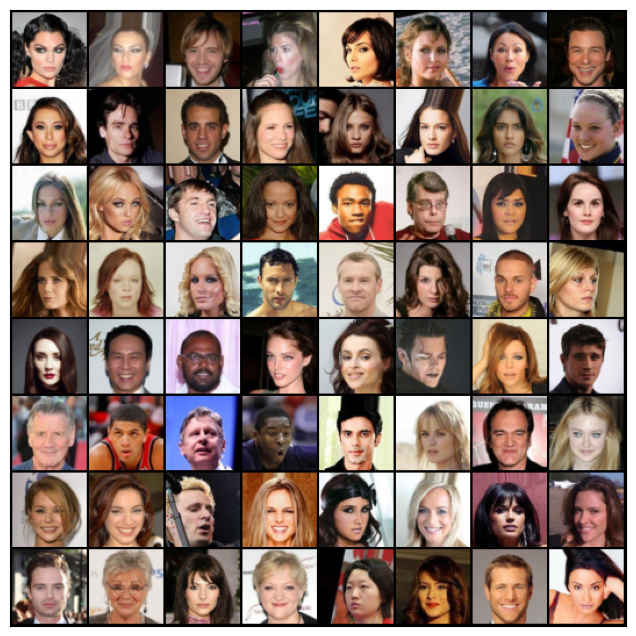

In [8]:
show_batch(train_dataloader)

### Building the models

Discriminator

In [9]:
discriminator = nn.Sequential(
    nn.Conv2d(3,64,kernel_size=4, stride= 2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),
    
    #nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    #nn.BatchNorm2d(1024),
    #nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(512,1, kernel_size=4, stride=1, padding=0, bias=False),
    
    nn.Flatten(),
    nn.Sigmoid()
    
)

In [11]:
discriminator = discriminator.to(device)

Generator Network

In [12]:
latent_size = 128

generator = nn.Sequential(
    #nn.ConvTranspose2d(latent_size,1024, kernel_size=4, stride=2, padding=0, bias=False),
    #nn.BatchNorm2d(1024),
    #nn.ReLU(True),
    
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

### Display the images the generator makes with no training

At this point the images are random and will look like noise.

torch.Size([256, 3, 64, 64])


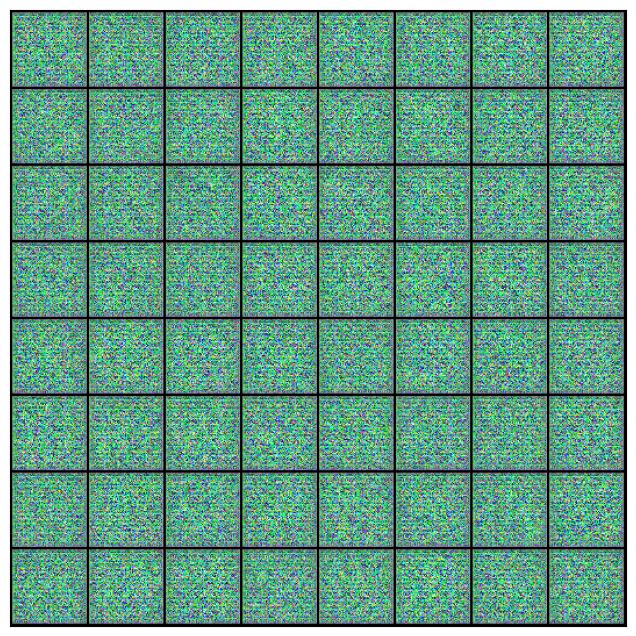

In [14]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [15]:
generator = generator.to(device)

### Training loop functions

The aim for these two model is for the generator to be trying to trick the discriminator model with the images it produces to be seen as real whilst the dicriminator model is trying to get better at telling real and fake images apart.

Discriminator model training loop

In [16]:
def train_discriminator(real_images, d_opt):
    '''
    Here the model will look at one batch of real images and the target is set to 1 then the model looks
    at a batch of fake images with the target set to 0 and the losses are added up at the end.
    '''   
    real_images = real_images.to(device)
    d_opt.zero_grad()
    
    #Disriminator looks at real images
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    #Generate fake images
    latent = torch.randn(batch_size, latent_size, 1,1, device=device)
    fake_images = generator(latent)
    
    #Disriminator looks at fake images
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    #Update discrim
    loss = real_loss + fake_loss
    loss.backward()
    d_opt.step()
    return loss.item(), real_score, fake_score

Generator model training loop

In [17]:
def train_generator(g_opt):
    g_opt.zero_grad()
    
    #Generate fake image
    latent = torch.randn(batch_size, latent_size, 1,1, device=device)
    fake_images = generator(latent)
    
    #Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds,targets)
    
    #Update generator model
    loss.backward()
    g_opt.step()
    
    return loss.item()

In [18]:
sample_images_location = "samples_round_3"
os.makedirs(sample_images_location, exist_ok=True)

Save the sample images for later on 

In [19]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated=images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_images_location, fake_fname), nrow=8)
    #print("Saving", fake_fname)
    
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [20]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


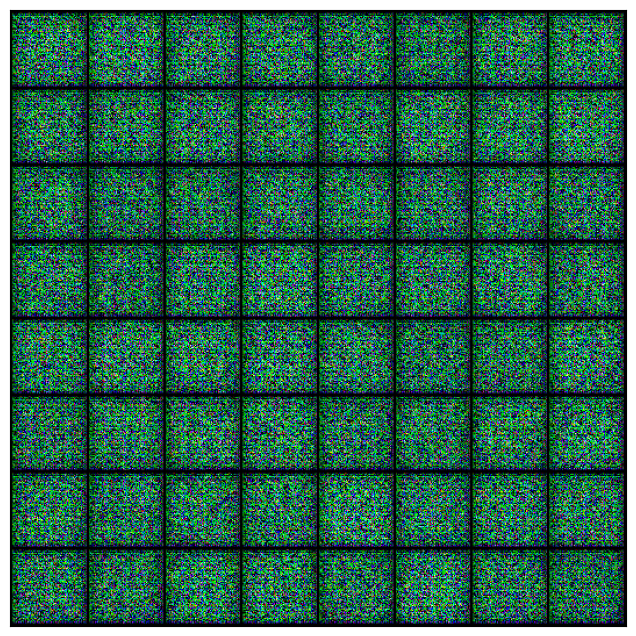

In [21]:
save_samples(0, fixed_latent)

In [22]:
def fit(epochs, lr, start_idx = 1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    d_opt = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    g_opt = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    print("Training starting...")
    for epoch in range(epochs):
        start = time.time()
        for real_images, _ in train_dataloader:
            real_images = real_images.to(device) 
            
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, d_opt)
            # Train generator
            loss_g = train_generator(g_opt)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        end = time.time()
        time_el = end - start
        print(f"Epoch [{epoch+1:03d}/{epochs}] | loss_g: {loss_g:.4f}, loss_d: {loss_d:.4f} | real_score: {real_score:.4f}, fake_score: {fake_score:.4f} | [Time : {time_el:.1f}S]")
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
        

    return losses_g, losses_d, real_scores, fake_scores

** Note ** 

I'm training this model over night so have set the epochs quite high at 250 which will probably be too many.

In [23]:
lr = 0.00025
epochs = 250

In [24]:
big_start  = time.time()
history = fit(epochs, lr)
big_end = time.time()

print(f"\nTotal time taken {((big_end-big_start)/60)/60} Hours")

Training starting...
Epoch [001/250] | loss_g: 1.7047, loss_d: 0.7060 | real_score: 0.6108, fake_score: 0.0719 | [Time : 111.3S]
Epoch [002/250] | loss_g: 1.9867, loss_d: 3.6694 | real_score: 0.0540, fake_score: 0.0004 | [Time : 110.8S]
Epoch [003/250] | loss_g: 2.0729, loss_d: 0.2773 | real_score: 0.8109, fake_score: 0.0463 | [Time : 110.8S]
Epoch [004/250] | loss_g: 3.7387, loss_d: 0.1601 | real_score: 0.9082, fake_score: 0.0565 | [Time : 110.9S]
Epoch [005/250] | loss_g: 1.4751, loss_d: 2.6642 | real_score: 0.0995, fake_score: 0.0007 | [Time : 110.9S]
Epoch [006/250] | loss_g: 4.3776, loss_d: 0.6644 | real_score: 0.9542, fake_score: 0.4101 | [Time : 110.7S]
Epoch [007/250] | loss_g: 2.2948, loss_d: 0.3746 | real_score: 0.7799, fake_score: 0.0787 | [Time : 110.7S]
Epoch [008/250] | loss_g: 6.1144, loss_d: 0.6103 | real_score: 0.9905, fake_score: 0.4152 | [Time : 110.7S]
Epoch [009/250] | loss_g: 3.0824, loss_d: 0.1084 | real_score: 0.9279, fake_score: 0.0287 | [Time : 110.7S]
Epoch [

Epoch [077/250] | loss_g: 4.7516, loss_d: 0.2243 | real_score: 0.9406, fake_score: 0.1141 | [Time : 110.8S]
Epoch [078/250] | loss_g: 2.7346, loss_d: 0.1235 | real_score: 0.9178, fake_score: 0.0215 | [Time : 110.8S]
Epoch [079/250] | loss_g: 4.5708, loss_d: 0.1232 | real_score: 0.9034, fake_score: 0.0104 | [Time : 110.8S]
Epoch [080/250] | loss_g: 5.5604, loss_d: 0.0663 | real_score: 0.9759, fake_score: 0.0366 | [Time : 110.7S]
Epoch [081/250] | loss_g: 7.1475, loss_d: 0.1189 | real_score: 0.9947, fake_score: 0.0919 | [Time : 110.7S]
Epoch [082/250] | loss_g: 6.7210, loss_d: 0.0149 | real_score: 0.9929, fake_score: 0.0074 | [Time : 110.8S]
Epoch [083/250] | loss_g: 4.2426, loss_d: 0.0959 | real_score: 0.9413, fake_score: 0.0266 | [Time : 111.0S]
Epoch [084/250] | loss_g: 7.1504, loss_d: 0.0185 | real_score: 0.9956, fake_score: 0.0137 | [Time : 110.9S]
Epoch [085/250] | loss_g: 5.6284, loss_d: 0.0201 | real_score: 0.9918, fake_score: 0.0112 | [Time : 110.8S]
Epoch [086/250] | loss_g: 6.

Epoch [153/250] | loss_g: 7.2758, loss_d: 0.0241 | real_score: 0.9880, fake_score: 0.0104 | [Time : 110.8S]
Epoch [154/250] | loss_g: 5.7972, loss_d: 0.0372 | real_score: 0.9881, fake_score: 0.0221 | [Time : 110.8S]
Epoch [155/250] | loss_g: 5.1060, loss_d: 0.2227 | real_score: 0.9561, fake_score: 0.1136 | [Time : 110.9S]
Epoch [156/250] | loss_g: 20.0108, loss_d: 1.3845 | real_score: 0.9999, fake_score: 0.5912 | [Time : 110.6S]
Epoch [157/250] | loss_g: 7.0785, loss_d: 0.0192 | real_score: 0.9940, fake_score: 0.0124 | [Time : 110.8S]
Epoch [158/250] | loss_g: 6.6951, loss_d: 0.0175 | real_score: 0.9898, fake_score: 0.0068 | [Time : 110.6S]
Epoch [159/250] | loss_g: 4.9678, loss_d: 0.3601 | real_score: 0.7909, fake_score: 0.0179 | [Time : 110.7S]
Epoch [160/250] | loss_g: 5.5021, loss_d: 0.0529 | real_score: 0.9665, fake_score: 0.0130 | [Time : 110.6S]
Epoch [161/250] | loss_g: 4.0999, loss_d: 0.1525 | real_score: 0.9183, fake_score: 0.0248 | [Time : 110.8S]
Epoch [162/250] | loss_g: 6

Epoch [229/250] | loss_g: 3.0574, loss_d: 0.2802 | real_score: 0.8533, fake_score: 0.0482 | [Time : 110.8S]
Epoch [230/250] | loss_g: 6.0492, loss_d: 0.0323 | real_score: 0.9866, fake_score: 0.0169 | [Time : 110.9S]
Epoch [231/250] | loss_g: 5.2283, loss_d: 0.0209 | real_score: 0.9915, fake_score: 0.0114 | [Time : 111.1S]
Epoch [232/250] | loss_g: 5.1127, loss_d: 0.0950 | real_score: 0.9686, fake_score: 0.0479 | [Time : 111.1S]
Epoch [233/250] | loss_g: 7.4697, loss_d: 0.0860 | real_score: 0.9874, fake_score: 0.0559 | [Time : 110.9S]
Epoch [234/250] | loss_g: 5.4481, loss_d: 0.1036 | real_score: 0.9365, fake_score: 0.0267 | [Time : 110.8S]
Epoch [235/250] | loss_g: 7.0279, loss_d: 0.0680 | real_score: 0.9906, fake_score: 0.0456 | [Time : 111.0S]
Epoch [236/250] | loss_g: 5.2074, loss_d: 0.0986 | real_score: 0.9737, fake_score: 0.0522 | [Time : 111.2S]
Epoch [237/250] | loss_g: 4.1097, loss_d: 0.2075 | real_score: 0.8829, fake_score: 0.0343 | [Time : 111.2S]
Epoch [238/250] | loss_g: 6.

### Save the model checkpoints 

In [25]:
 torch.save(generator.state_dict(), 'Gen3.pth')
torch.save(discriminator.state_dict(), 'Dis3.pth')

### Plot some graphs

In [27]:
losses_g, losses_d, real_scores, fake_scores = history

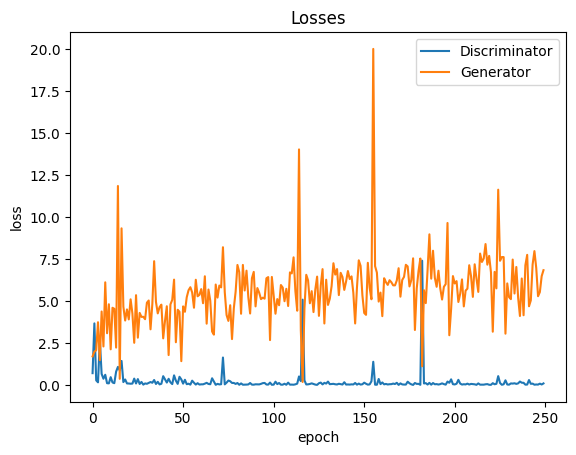

In [28]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');
plt.show()

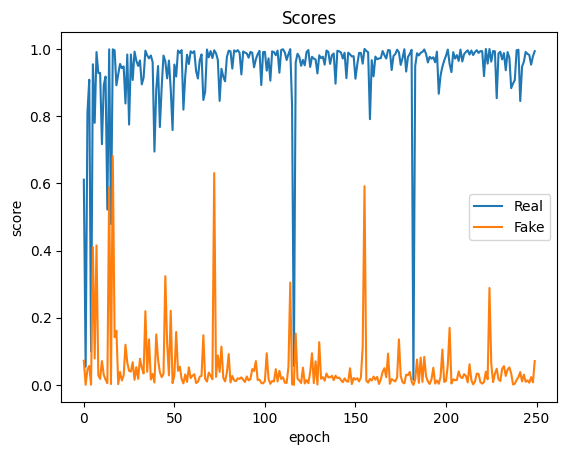

In [29]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');